In [1]:
%matplotlib inline
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Input, Dense, Conv2D, MaxPooling2D,\
    UpSampling2D, Dropout, Activation, Flatten, Reshape, merge, Conv2DTranspose
from keras.layers.normalization import BatchNormalization
from keras.datasets import mnist
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam, RMSprop
from keras.initializers import Initializer, RandomNormal
from keras.regularizers import l2
from keras.models import Model
from PIL import Image
import scipy.misc
import matplotlib.pyplot as plt
from scipy.misc import imsave
import bcolz
import random

Using TensorFlow backend.


In [2]:
'''Note that in the paper, the output of the generative model
is tanh activation layer, which will be the input to our
discriminative model. So we need to normalize input images 
to tanh scale (-1.0 to 1.0)'''

(x_train, y_train), (x_test_, y_test_) = mnist.load_data()
x_train = (x_train.astype(np.float32)/255.0) * 2.0 - 1.0
x_train = np.expand_dims(x_train, axis=3)

In [3]:
'''Discriminator network'''
discriminator_input = Input(x_train.shape[1:])
discriminator_x = Conv2D(256, (5,5), strides=(2, 2), padding = 'same',
          kernel_regularizer = l2(0.0001))(discriminator_input)
discriminator_x = LeakyReLU(0.2)(discriminator_x)
discriminator_x = Dropout(0.5)(discriminator_x)

discriminator_x = Conv2D(512, (5,5), strides=(2, 2), padding = 'same',
          kernel_regularizer = l2(0.0001))(discriminator_x)
discriminator_x = LeakyReLU(0.2)(discriminator_x)
discriminator_x = Dropout(0.5)(discriminator_x)
discriminator_x = Flatten()(discriminator_x)

discriminator_x = Dense(256, kernel_regularizer = l2(0.0001))(discriminator_x)
discriminator_x = LeakyReLU(0.2)(discriminator_x)
discriminator_x = Dropout(0.5)(discriminator_x)

discriminator_x = Dense(1,activation='sigmoid')(discriminator_x)

discriminator_model = Model(discriminator_input,discriminator_x)
discriminator_model.compile(RMSprop(lr=0.00005),loss='mean_squared_error')

In [4]:
'''Generator network'''
generator_input = Input((100,))
generator_x = Dense(512*7*7, kernel_initializer=RandomNormal(
                                   mean=0.0, stddev=0.02))(generator_input)
generator_x = BatchNormalization()(generator_x)
generator_x = Activation('relu')(generator_x)
generator_x = Reshape((7,7,512))(generator_x)
generator_x = UpSampling2D()(generator_x)

generator_x = Conv2D(256, (3,3), padding='same', 
                  kernel_initializer=RandomNormal(
                                   mean=0.0, stddev=0.02))(generator_x)
generator_x = BatchNormalization()(generator_x)
generator_x = Activation('relu')(generator_x)
generator_x = UpSampling2D()(generator_x)

generator_x = Conv2D(128, (3,3), padding='same',
                  kernel_initializer=RandomNormal(
                                   mean=0.0, stddev=0.02))(generator_x)
generator_x = BatchNormalization()(generator_x)
generator_x = Activation('relu')(generator_x)

generator_x = Conv2D(64, (3,3), padding='same',
                  kernel_initializer=RandomNormal(
                                   mean=0.0, stddev=0.02))(generator_x)
generator_x = BatchNormalization()(generator_x)
generator_x = Activation('relu')(generator_x)

generator_x = Conv2D(1, (1,1), padding='same',
                  kernel_initializer=RandomNormal(
                                   mean=0.0, stddev=0.02))(generator_x)
generator_x = Activation('tanh')(generator_x)

generator_model = Model(generator_input,generator_x)
generator_model.compile(RMSprop(lr=0.00005),loss='mean_squared_error')

In [5]:
'''Freeze discriminator'''
discriminator_model.trainable = False
for layer in discriminator_model.layers:
    layer.trainable = False

'''GAN = generator + discriminator'''
gan_input = Input((100,))
gan_x = generator_model(gan_input)
gan_x = discriminator_model(gan_x)
model = Model(gan_input, gan_x)
model.compile(RMSprop(lr=0.00005), loss = "mean_squared_error")

In [6]:
'''Train discriminator for 1 epoch as a start'''
init_data = len(x_train)//6

real = np.random.permutation(x_train)[:init_data]
fake = generator_model.predict(np.random.rand(init_data,100))
x_init = np.concatenate((real,fake))

real_label = np.zeros((init_data,1))
fake_label = np.ones((init_data,1))
y_init = np.concatenate((real_label,fake_label))

In [7]:
'''Unfreeze discriminator'''
discriminator_model.trainable = True
for layer in discriminator_model.layers:
    layer.trainable = True

discriminator_model.fit(x_init,y_init,batch_size=128,epochs=1)
#Clamp the weights
for layer in discriminator_model.layers:
    weights = layer.get_weights()
    weights = [np.clip(w, -0.01, 0.01) for w in weights]
    layer.set_weights(weights)

Epoch 1/1
20000/20000 [==============================] - 5s - loss: 0.0840     


In [8]:
discriminator_loss = []
generator_loss = []
num_data = len(x_train)

In [26]:
'''Note that our discriminator and generator models are referenced
by our GAN and we do not want the discriminator part of the GAN to be
trained when trying to minimize generator losses. To do so, we can just
do it by freezing discriminator model before training the generator'''

model.optimizer = RMSprop(lr=0.00005)
discriminator_model.optimizer = RMSprop(lr=0.00005)
generator_model.optimizer = RMSprop(lr=0.00005)

num_iterations = 50000
real_per_iter = 64
fake_per_iter = 64

real_label = np.zeros((real_per_iter,1))
fake_label = np.ones((fake_per_iter,1))
y_mini = np.concatenate((real_label,fake_label))

repeat_discriminator = 100
repeat_generator = 1

for i in range(num_iterations):
    print('Iteration #%d' % i)
    if (len(discriminator_loss)>25):
        repeat_discriminator = 5
    
    '''Unfreeze discriminator'''
    discriminator_model.trainable = True
    for layer in discriminator_model.layers:
        layer.trainable = True
        
    '''Training discriminator'''
    for k in range(repeat_discriminator):
        '''Create real and fake data, as well as their labels'''
        real = x_train[np.random.randint(0,high=num_data,size=real_per_iter)]
        fake = generator_model.predict(np.random.rand(fake_per_iter,100))
        x_mini = np.concatenate((real, fake))
        discriminator_loss.append(discriminator_model.train_on_batch(x_mini,y_mini))
        #Clamp the weights
        for layer in discriminator_model.layers:
            weights = layer.get_weights()
            weights = [np.clip(w, -0.01, 0.01) for w in weights]
            layer.set_weights(weights)
    
    '''Freeze discriminator'''
    discriminator_model.trainable = False
    for layer in discriminator_model.layers:
        layer.trainable = False
    
    '''Training generator'''
    for k in range(repeat_generator):
        generator_x = np.random.rand(fake_per_iter*2,100)
        generator_y = np.zeros((fake_per_iter*2,1)) #we want it to be classified as real
        generator_loss.append(model.train_on_batch(generator_x, generator_y))
    
    '''Show losses'''
    print('Discriminator loss = %.6f Generator loss = %.6f'
          % (discriminator_loss[len(discriminator_loss)-1],
             generator_loss[len(generator_loss)-1]))

Iteration #0
Discriminator loss = 0.250558 Generator loss = 0.250875
Iteration #1
Discriminator loss = 0.251517 Generator loss = 0.250995
Iteration #2
Discriminator loss = 0.251219 Generator loss = 0.249265
Iteration #3
Discriminator loss = 0.249824 Generator loss = 0.251471
Iteration #4
Discriminator loss = 0.250932 Generator loss = 0.249792
Iteration #5
Discriminator loss = 0.251938 Generator loss = 0.253131
Iteration #6
Discriminator loss = 0.250284 Generator loss = 0.253649
Iteration #7
Discriminator loss = 0.250149 Generator loss = 0.255158
Iteration #8
Discriminator loss = 0.249793 Generator loss = 0.251296
Iteration #9
Discriminator loss = 0.250399 Generator loss = 0.250522
Iteration #10
Discriminator loss = 0.250312 Generator loss = 0.248285
Iteration #11
Discriminator loss = 0.250790 Generator loss = 0.254515
Iteration #12
Discriminator loss = 0.251023 Generator loss = 0.253227
Iteration #13
Discriminator loss = 0.250380 Generator loss = 0.253586
Iteration #14
Discriminator lo

Discriminator loss = 0.250653 Generator loss = 0.250366
Iteration #118
Discriminator loss = 0.249806 Generator loss = 0.252746
Iteration #119
Discriminator loss = 0.252857 Generator loss = 0.252397
Iteration #120
Discriminator loss = 0.252137 Generator loss = 0.251196
Iteration #121
Discriminator loss = 0.250853 Generator loss = 0.253280
Iteration #122
Discriminator loss = 0.250962 Generator loss = 0.252955
Iteration #123
Discriminator loss = 0.251094 Generator loss = 0.251276
Iteration #124
Discriminator loss = 0.250868 Generator loss = 0.250315
Iteration #125
Discriminator loss = 0.250832 Generator loss = 0.251381
Iteration #126
Discriminator loss = 0.252267 Generator loss = 0.252604
Iteration #127
Discriminator loss = 0.249689 Generator loss = 0.250603
Iteration #128
Discriminator loss = 0.251117 Generator loss = 0.252913
Iteration #129
Discriminator loss = 0.251710 Generator loss = 0.250910
Iteration #130
Discriminator loss = 0.248835 Generator loss = 0.252432
Iteration #131
Discri

Discriminator loss = 0.251224 Generator loss = 0.251722
Iteration #234
Discriminator loss = 0.252206 Generator loss = 0.251192
Iteration #235
Discriminator loss = 0.251852 Generator loss = 0.252931
Iteration #236
Discriminator loss = 0.251658 Generator loss = 0.250283
Iteration #237
Discriminator loss = 0.251517 Generator loss = 0.249254
Iteration #238
Discriminator loss = 0.252098 Generator loss = 0.251145
Iteration #239
Discriminator loss = 0.250632 Generator loss = 0.247699
Iteration #240
Discriminator loss = 0.251655 Generator loss = 0.247155
Iteration #241
Discriminator loss = 0.250684 Generator loss = 0.248614
Iteration #242
Discriminator loss = 0.250877 Generator loss = 0.248503
Iteration #243
Discriminator loss = 0.250391 Generator loss = 0.250970
Iteration #244
Discriminator loss = 0.250170 Generator loss = 0.248162
Iteration #245
Discriminator loss = 0.251453 Generator loss = 0.252953
Iteration #246
Discriminator loss = 0.250797 Generator loss = 0.247667
Iteration #247
Discri

Discriminator loss = 0.251296 Generator loss = 0.247218
Iteration #350
Discriminator loss = 0.251336 Generator loss = 0.248782
Iteration #351
Discriminator loss = 0.250765 Generator loss = 0.250885
Iteration #352
Discriminator loss = 0.250771 Generator loss = 0.250918
Iteration #353
Discriminator loss = 0.249965 Generator loss = 0.248873
Iteration #354
Discriminator loss = 0.249841 Generator loss = 0.251673
Iteration #355
Discriminator loss = 0.249786 Generator loss = 0.252221
Iteration #356
Discriminator loss = 0.249904 Generator loss = 0.250356
Iteration #357
Discriminator loss = 0.251295 Generator loss = 0.252040
Iteration #358
Discriminator loss = 0.251477 Generator loss = 0.250936
Iteration #359
Discriminator loss = 0.251059 Generator loss = 0.252850
Iteration #360
Discriminator loss = 0.251382 Generator loss = 0.249845
Iteration #361
Discriminator loss = 0.251295 Generator loss = 0.249538
Iteration #362
Discriminator loss = 0.251041 Generator loss = 0.251294
Iteration #363
Discri

Discriminator loss = 0.249556 Generator loss = 0.251784
Iteration #466
Discriminator loss = 0.251537 Generator loss = 0.251385
Iteration #467
Discriminator loss = 0.250833 Generator loss = 0.252907
Iteration #468
Discriminator loss = 0.250631 Generator loss = 0.252231
Iteration #469
Discriminator loss = 0.250267 Generator loss = 0.252649
Iteration #470
Discriminator loss = 0.251176 Generator loss = 0.253448
Iteration #471
Discriminator loss = 0.249530 Generator loss = 0.251486
Iteration #472
Discriminator loss = 0.250583 Generator loss = 0.251318
Iteration #473
Discriminator loss = 0.250893 Generator loss = 0.249350
Iteration #474
Discriminator loss = 0.250038 Generator loss = 0.250128
Iteration #475
Discriminator loss = 0.250124 Generator loss = 0.248421
Iteration #476
Discriminator loss = 0.250640 Generator loss = 0.250142
Iteration #477
Discriminator loss = 0.250387 Generator loss = 0.249621
Iteration #478
Discriminator loss = 0.249563 Generator loss = 0.249779
Iteration #479
Discri

Discriminator loss = 0.250117 Generator loss = 0.255191
Iteration #582
Discriminator loss = 0.250649 Generator loss = 0.257392
Iteration #583
Discriminator loss = 0.250920 Generator loss = 0.256153
Iteration #584
Discriminator loss = 0.251870 Generator loss = 0.254514
Iteration #585
Discriminator loss = 0.250407 Generator loss = 0.253549
Iteration #586
Discriminator loss = 0.249787 Generator loss = 0.252760
Iteration #587
Discriminator loss = 0.250379 Generator loss = 0.250390
Iteration #588
Discriminator loss = 0.249677 Generator loss = 0.247966
Iteration #589
Discriminator loss = 0.249134 Generator loss = 0.246852
Iteration #590
Discriminator loss = 0.250675 Generator loss = 0.249274
Iteration #591
Discriminator loss = 0.251071 Generator loss = 0.250821
Iteration #592
Discriminator loss = 0.250803 Generator loss = 0.249011
Iteration #593
Discriminator loss = 0.250327 Generator loss = 0.252225
Iteration #594
Discriminator loss = 0.251350 Generator loss = 0.252476
Iteration #595
Discri

KeyboardInterrupt: 

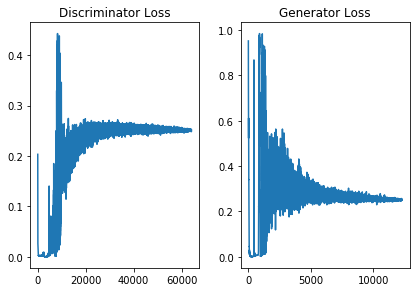

In [27]:
'''Plot discriminator and generator losses'''
figure,axis = plt.subplots(1,2)
plt.tight_layout()
axis[0].plot(discriminator_loss)
axis[0].set_title("Discriminator Loss")
axis[1].plot(generator_loss)
axis[1].set_title("Generator Loss")

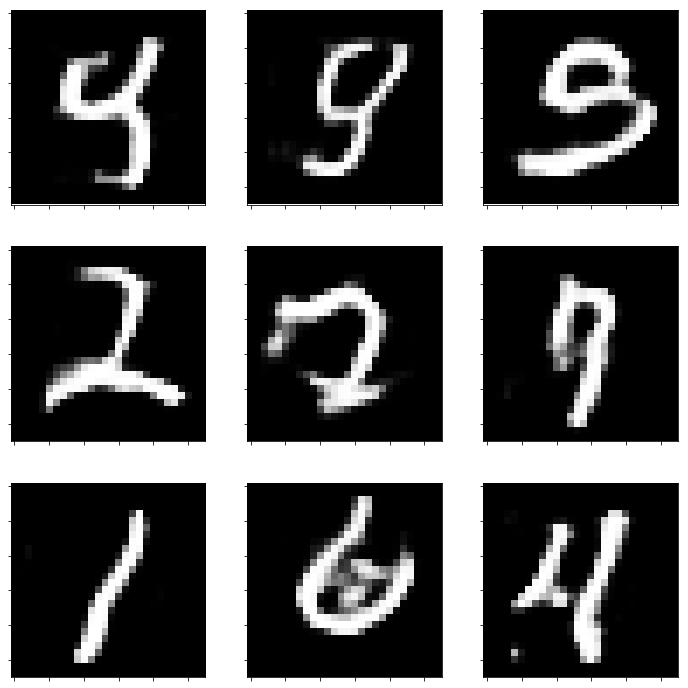

In [32]:
'''Generate images with our trained generator model'''
num_generated = 9
in_noise = np.random.rand(num_generated,100)
im = generator_model.predict(in_noise)
im = im[:,:,:,0]
figure,axis = plt.subplots(3,3,figsize=(10,10))
plt.tight_layout()
for i in range(3):
    for j in range(3):
        axis[i,j].imshow(im[i*3+j],cmap='gray')
        axis[i,j].set_yticklabels([])
        axis[i,j].set_xticklabels([])

In [ ]:
'''Save weights and models'''
discriminator_model.save_weights('wasserstein_mnist_discriminator_deepmodel_weights.h5')
generator_model.save_weights('wasserstein_mnist_generator_deepmodel_weights.h5')
model.save_weights('wasserstein_mnist_gan_deepmodel_weights.h5')

discriminator_model.save('wasserstein_mnist_discriminator_deepmodel.h5')
generator_model.save('wasserstein_mnist_generator_deepmodel.h5')
model.save('wasserstein_mnist_gan_deepmodel.h5')